In [7]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')

En el pair programming de hoy debéis usar el csv que guardastéis cuando hicistéis el pairprgramming de codificicación (este csv debería tener las variables estadandarizas).

En pairprogramming anteriores ajustastéis vuestro datos a una regresión lineal. El objetivo de hoy es:

>- Ajustar el modelo a un Decision Tree


In [8]:
df=pd.read_csv('datos/coches_encoding_final.csv', index_col=0)

In [9]:
#MODELO DECISSION TREE

# al igual que en la regresión lineal tenemos que separar nuestro dataframe en X e y

X = df.drop("price_BOX", axis = 1)
y = df["price_BOX"]


In [10]:

# y dividir nuestros datos en train y test para poder evaluar la bondad de nuestro modelo

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


In [14]:
# creamos el objeto del modelo, al igual que hacíamos en la regresión lineal
arbol = DecisionTreeRegressor(random_state =42)  #Como no sabemos la profundidad adecuada, 
                    #dejamos que le modelo lo haga con todas las variables y más adelante, elegiremos la que mejor ha predicho los datos.


In [15]:
# ajustamos el modelo, igual que en la regresión lienal. 
arbol.fit(x_train, y_train)


DecisionTreeRegressor(random_state=42)

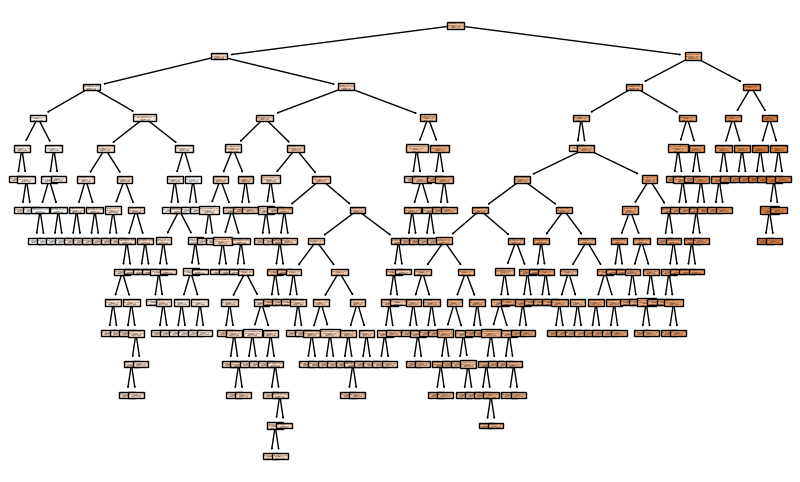

In [16]:
#Para mostrar el modelo en arbol
fig = plt.figure(figsize = (10,6))  
tree.plot_tree(arbol, feature_names = x_train.columns, filled = True)
plt.show();


In [18]:
#HIPER-PARÁMETROS

# max features. Como vemos, debemos poner en nuestro modelo una profudidad máxima de 4. 

max_features = np.sqrt(len(x_train.columns))
max_features


4.898979485566356

In [19]:

# max depth compruebo
print(arbol.tree_.max_depth)


14


In [20]:
# hacemos las predicciones sobre los dos set de datos el X_test y el X_train

y_pred_test_dt = arbol.predict(x_test)
y_pred_train_dt = arbol.predict(x_train)


>- Extraer las métricas

In [21]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df


In [23]:

# sacamos las métricas para ver si hay overfitting o unerfitting, para modificar la profundidad en función de estos resultados

dt_results1 = metricas(y_test, y_train, y_pred_test_dt, y_pred_train_dt, "Decission Tree I")
dt_results1.head()




,MAE,MSE,RMSE,R2,set,modelo
0,0.000336,1.714656e-07,0.000414,0.931559,test,Decission Tree I
1,0.000013,3.316720e-09,0.000058,0.998367,train,Decission Tree I


In [24]:
# MODELO II DECISION TREE PARA ESTABLECER LA PROFUNDIDAD DEL PROPIO MODELO

# lo primero que tenemos que hacer es definir un diccionario con los hiperparámetros que queremos modificar 
# y los valores que queremos 

param = {"max_depth": [2,4, 6], # teniendo en cuenta que teníamos overfitting tendremos que reducir la profundidad del modelo, 
                                #la nuestra anterior era de 17. Bajaremos mucho este valor ya que teníamos un overfitting muy claro
        "max_features": [1,2,3,4],# calculamos en celdas anteriores, probaremos a hacer el modelo como una variable, 2, 3 y 4. 
                                #Ponemos como límite el 4 ya que es el resultado de la raiz cuadrada. 

        # estos dos hiperparámetros son más difíciles de definir, pero usualmente se suelen elegir los siguientes valores
        "min_samples_split": [10, 50, 100],
        "min_samples_leaf": [10,50,100]} 


In [26]:
# una vez creado el diccionario iniciaremos el modelo con GridSearch

gs = GridSearchCV(
            estimator=DecisionTreeRegressor(), # tipo de modelo que queremos hacer
            param_grid= param, # que hiperparámetros queremos que testee
            cv=10, # crossvalidation que aprendimos en la lección de regresión lineal intro. 
            verbose=-1, # para que no nos printee ningún mensaje en pantalla
            return_train_score = True, # para que nos devuelva el valor de las métricas de set de datos de entrenamiento
            scoring="neg_mean_squared_error") # la métrica que queremos que nos devuelva


In [27]:
# ajustamos el modelo que acabamos de definir en el GridSearch

gs.fit(x_train, y_train)


GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [2, 4, 6], 'max_features': [1, 2, 3, 4],
                         'min_samples_leaf': [10, 50, 100],
                         'min_samples_split': [10, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [30]:

# este método (BEST_ESTIMATOR) nos esta diciendo que el mejor modelo es aquel que tiene una profundidad de 6, que usa 4 
# variables predictoras para construir el modelo y que tiene  un min_samples_leaf y un min_samples_split de 10. 
mejor_modelo = gs.best_estimator_
mejor_modelo

DecisionTreeRegressor(max_depth=6, max_features=4, min_samples_leaf=10,
                      min_samples_split=10)

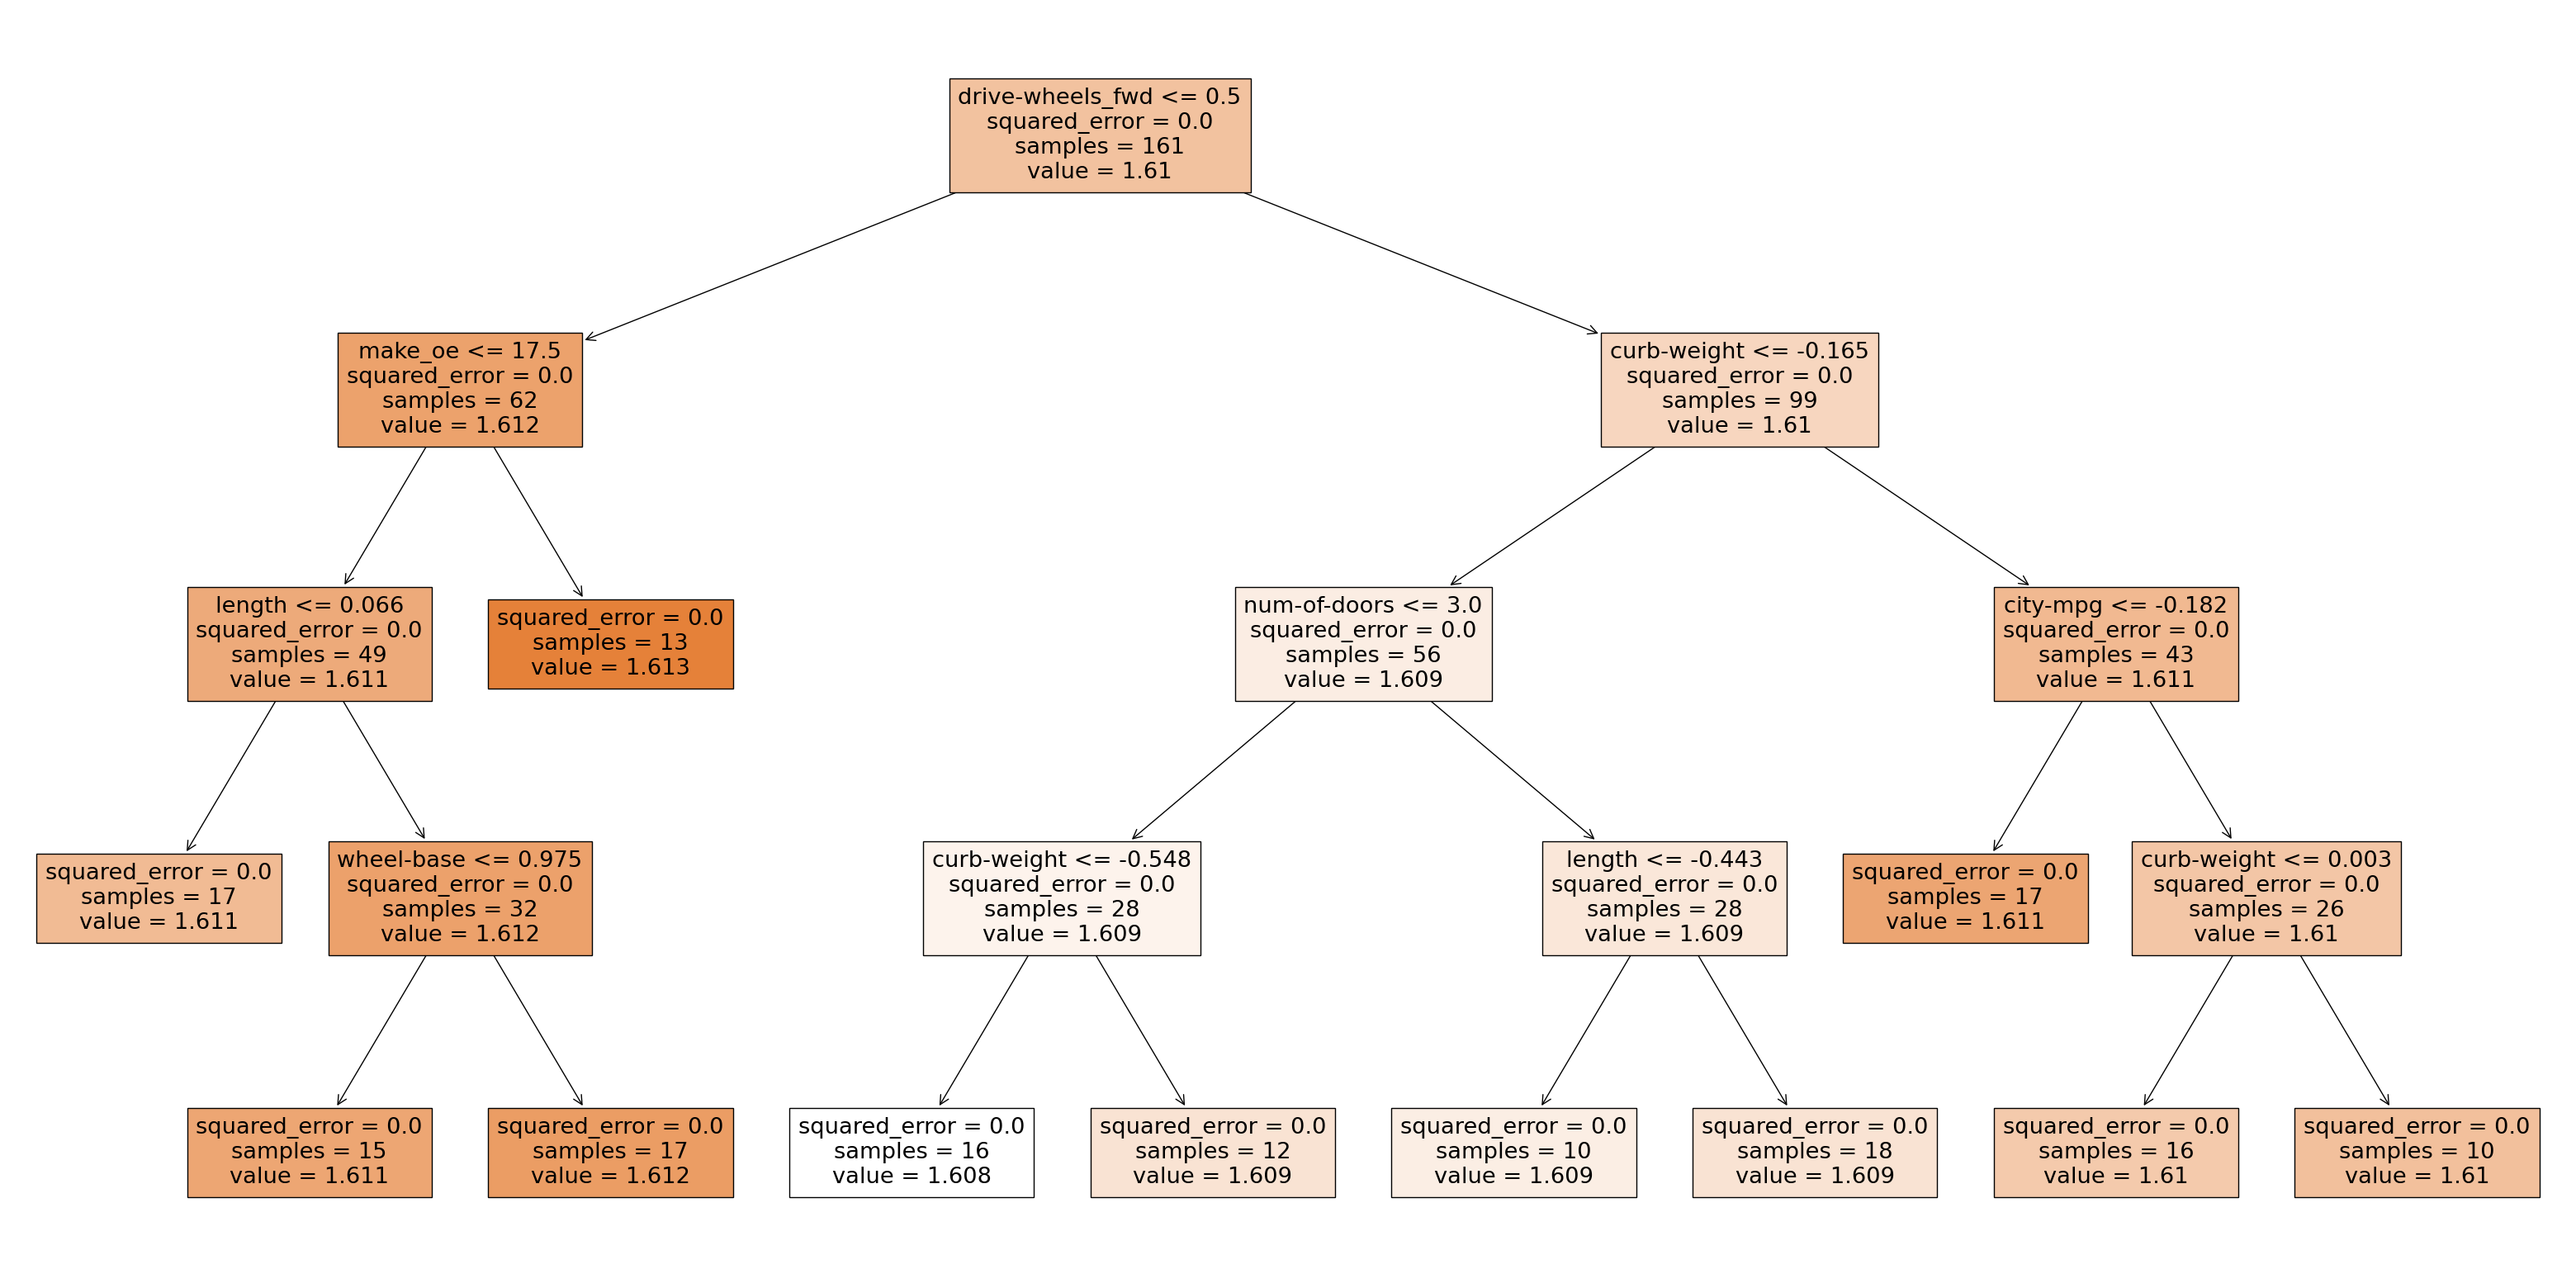

In [29]:

# veamos ahora que pinta tiene nuestro árbol

fig = plt.figure(figsize=(40, 20))
tree.plot_tree(mejor_modelo, feature_names=x_train.columns, filled=True);

In [31]:
#MÉTRICAS PARA COMPROBAR LA CALIDAD DEL MODELO

y_pred_test_dt2 = mejor_modelo.predict(x_test)
y_pred_train_dt2 = mejor_modelo.predict(x_train)


In [32]:

dt_results2 = metricas(y_test, y_train, y_pred_test_dt2, y_pred_train_dt2, "Decision tree II")
dt_results2


,MAE,MSE,RMSE,R2,set,modelo
0,0.000566,4.761390e-07,0.000690,0.809949,test,Decision tree II
1,0.000406,2.888712e-07,0.000537,0.857797,train,Decision tree II


In [34]:

# vamos  a juntar los dataframes de los resultados de los modelos para poder compararlos mejor

df_decision_results = pd.concat([dt_results1, dt_results2], axis = 0)
df_decision_results


,MAE,MSE,RMSE,R2,set,modelo
0,0.000336,1.714656e-07,0.000414,0.931559,test,Decission Tree I
1,0.000013,3.316720e-09,0.000058,0.998367,train,Decission Tree I
0,0.000566,4.761390e-07,0.000690,0.809949,test,Decision tree II
1,0.000406,2.888712e-07,0.000537,0.857797,train,Decision tree II


In [35]:

# Abrimos el csv con nuestros resultado de LR para así comprobar el mejor modelo

df_linear_results = pd.read_csv("datos/coches_resultados_LR.csv", index_col = 0)


In [36]:

# concatenamos todos los resultados

df_DT_LR_results = pd.concat([df_linear_results, df_decision_results], axis = 0)
df_DT_LR_results

,MAE,MSE,RMSE,R2,set,modelo
0,0.000342,2.067830e-07,0.000455,0.917462,test,Linear Regresion
1,0.000347,1.971630e-07,0.000444,0.902942,train,LinearRegression
0,0.000336,1.714656e-07,0.000414,0.931559,test,Decission Tree I
1,0.000013,3.316720e-09,0.000058,0.998367,train,Decission Tree I
0,0.000566,4.761390e-07,0.000690,0.809949,test,Decision tree II
1,0.000406,2.888712e-07,0.000537,0.857797,train,Decision tree II


In [40]:
# COMPROBACIÓN DE LA IMPORTANCIA DE VARIABLES PREDICTORAS

# vamos a crearnos un dataframe 
importancia_predictores = pd.DataFrame(
                            {'predictor': x_train.columns,
                             'importancia': mejor_modelo.feature_importances_}
                            )


In [41]:

# ordenamos de mayor a menor los resultados
importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)


In [42]:

# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores


Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
20,drive-wheels_fwd,0.490290
5,curb-weight,0.327003
11,make_oe,0.079979
9,city-mpg,0.051230
2,length,0.038151
0,num-of-doors,0.010024
1,wheel-base,0.003323
15,body_style_hardtop,0.000000
22,engine-location_front,0.000000
21,drive-wheels_rwd,0.000000


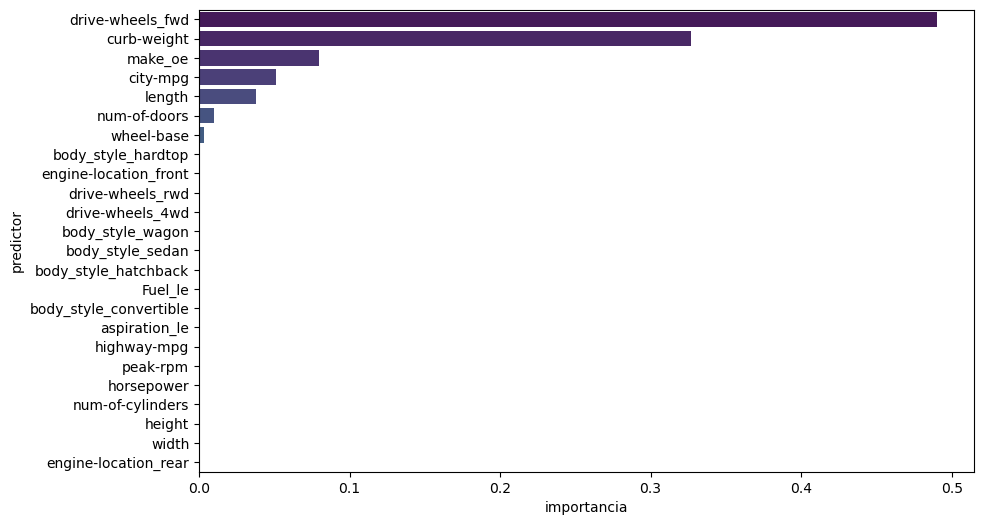

In [43]:

# por último ploteamos los resultados para verlo de una forma más amigable. 

plt.figure(figsize=(10,6))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores, palette="viridis");
plt.show()

>- Debatid entre vosotras que modelo es mejor y por qué (basándose en las métricas)

- He visto que el mejor modelo para predecir ha sido el DecisionTreeI. Aunque he comprobado que las variables con más importancia, son variables que no tienen mucho sentido con mis resultados. 